In [1]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

import datetime
import pandas as pd
import numpy as np
from scipy.fft import fft
import string

from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.colors import ListedColormap
from matplotlib import gridspec
import matplotlib.lines as mlines
import seaborn as sns
import skill_metrics as sm
from sklearn.metrics import r2_score

import matplotlib.patches as mpatches
from matplotlib.patches import ConnectionPatch

import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.colors as mcolors  # For RGBA to hex conversion
from matplotlib.gridspec import GridSpec

from src.plots import *
from src.utilities import cal_metrics, mielke_lambda, percentile_mean, fluctuation_frequency

In [2]:
TRANSECTS = ['Transect2', 'Transect5', 'Transect8'] # List of transects for evaluation


fp_input = 'datasets/shorelines' # File path for input data
fp_sub = 'submissions/{}' # File path for submission
fp_resub = 'resubmissions/{}' # File path for resubmission

fn_obs = 'shorelines_obs.csv' # File name for observed shoreline
fn_cali = 'shorelines_calibration.csv' # File name for calibration shoreline
fn_targ_short = 'shorelines_hidden_short.csv' # File name for target shoreline (short-term)
fn_targ_medium = 'shorelines_hidden_medium.csv' # File name for target shoreline (medium-term)
fn_pred_short = 'shorelines_prediction_short.csv' # File name for predicted shoreline (short-term)
fn_pred_medium = 'shorelines_prediction_medium.csv' # File name for predicted shoreline (medium-term)
fn_pred_RCP45 = 'shorelines_prediction_long_RCP45.csv' # File name for predicted shoreline (short-term)
fn_pred_RCP85 = 'shorelines_prediction_long_RCP85.csv' # File name for predicted shoreline (medium-term)

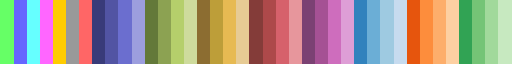

In [3]:
tab20b = plt.get_cmap('tab20b')
tab20c = plt.get_cmap('tab20c')
hsv = plt.get_cmap('hsv')

# Combine the colors
colors_tab20b = tab20b(np.linspace(0, 1, 20))
colors_tab20c = tab20c(np.linspace(0, 1, 20))[:-8, :]
combined_colors = np.vstack((np.array([[0.4, 1, 0.4, 1], [0.4, 0.4, 1, 1], [0.4, 1, 1, 1],
                                      [1, 0.4, 1, 1], [1, 0.8, 0, 1], [0.6, 0.6, 0.6, 1],
                                       [1, 0.4, 0.4, 1]]), 
                             colors_tab20b, colors_tab20c))


# Create a new colormap from the combined colors
cmap = plt.matplotlib.colors.ListedColormap(combined_colors)
cmap

In [4]:
# Read model metadata
df_meta = pd.read_excel('model_summary.xlsx', header=[1])
df_meta = df_meta[~df_meta['Model Name'].str.contains('corrected_JAAA')]
model_names = list(np.unique(df_meta['Model Name'].values))
MODEL_COLORS = dict(zip(model_names, cmap.colors[0:len(model_names)]))
MODEL_TYPES = dict(zip(df_meta['Model Name'], df_meta['Type']))
df_meta = df_meta[df_meta['Submission Type']=='Submission'].set_index('Model Name')

df_loss = pd.read_csv('figures/model_loss.csv', header=[0, 1], index_col=0).droplevel(0, axis=1).reset_index()
df_loss = df_loss[~df_loss['Model'].str.contains('*', regex=False)]

In [5]:
data_ranges = {
    'Short':pd.date_range(start='2019-01-01', end='2023-12-01'),
    'Medium':pd.date_range(start='1951-06-01', end='1998-10-01'),
}

fn_targs = {'Short':fn_targ_short,
           'Medium':fn_targ_medium}
sep_time = datetime.datetime(year=1986, month=1, day=1) # Separate medium prediction to two periods

In [6]:
COCOONED_list = df_loss[df_loss['Model'].str.contains('COCOONED')]['Model'].to_list()
best_COCOONED = df_loss[df_loss['Model'].str.contains('COCOONED')].set_index('Model').mean(1).sort_values().index[0]
COCOONED_list.remove(best_COCOONED)

ShorelineS_list = df_loss[df_loss['Model'].str.contains('ShorelineS')]['Model'].to_list()
best_ShorelineS = df_loss[df_loss['Model'].str.contains('ShorelineS')].set_index('Model').mean(1).sort_values().index[0]
ShorelineS_list.remove(best_ShorelineS)

CoSMoS_list = df_loss[df_loss['Model'].str.contains('CoSMoS')]['Model'].to_list()
best_CoSMoS = df_loss[df_loss['Model'].str.contains('CoSMoS')].set_index('Model').mean(1).sort_values().index[0]
CoSMoS_list.remove(best_CoSMoS)

LXShore_list = df_loss[df_loss['Model'].str.contains('LX-Shore')]['Model'].to_list()
best_LXShore = df_loss[df_loss['Model'].str.contains('LX-Shore')].set_index('Model').mean(1).sort_values().index[0]
LXShore_list.remove(best_LXShore)

ShoreFor_list = df_loss[df_loss['Model'].str.contains('ShoreFor')]['Model'].to_list()
best_ShoreFor = df_loss[df_loss['Model'].str.contains('ShoreFor')].set_index('Model').mean(1).sort_values().index[0]
ShoreFor_list.remove(best_ShoreFor)

model_remove = np.hstack([COCOONED_list, ShorelineS_list, CoSMoS_list, LXShore_list, ShoreFor_list])
model_remove = []

In [29]:
task = 'Medium'
fn_targ = fn_targs[task]
fn_pred = fn_targ.replace('hidden', 'prediction')
MODELS = list(df_meta.index)


# Read obs and calibration shoreline data
df_targ = pd.read_csv(os.path.join(fp_input, fn_targ), index_col='Datetime')
df_targ.index = pd.to_datetime(df_targ.index)
df_targ.sort_index(inplace=True)


dfs_pred = {}
freqs_pred = {} # This saves the frequency level of preds. High freq preds will be plotted on the bottom.
for model in MODELS:
    if df_meta.loc[model, 'Submission Type'] == 'Submission':
        fp = fp_sub

        if (os.path.exists(os.path.join(fp.format(model), fn_pred)))&(model not in model_remove):
            #if not ((model=='ShoreForCaCeHb_KS')|(model=='SegShoreFor_XC')):

            try:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='Datetime')
            except:
                df_pred = pd.read_csv(os.path.join(fp.format(model), fn_pred), index_col='datetime')
                df_pred.index.name = 'Datetime'
            df_pred.index = pd.to_datetime(df_pred.index)
            df_pred.sort_index(inplace=True)
            #df_pred = df_pred.reindex(data_ranges[task])
            if fp == fp_resub:
                model_new = model + '$^*$'
                if not model_new in MODEL_COLORS.keys():
                    MODEL_TYPES[model_new] = MODEL_TYPES.pop(model)
                    MODEL_COLORS[model_new] = MODEL_COLORS.pop(model)
                model = model_new

            if task=='Medium (post1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index>=sep_time]
            elif task=='Medium (pre1986)':
                dfs_pred[model] = df_pred.loc[df_pred.index<sep_time]
            else:
                dfs_pred[model] = df_pred
            freqs_pred[model] = df_pred.apply(fluctuation_frequency).median()
        
        
# Calculate ensembles
ensemble_values = []
index = data_ranges[task]

for key, df_pred in dfs_pred.items():
    ensemble_values.append(df_pred[TRANSECTS].resample('D').interpolate().reindex(index).values) 
ensemble_values = np.stack(ensemble_values)
#ensemble_mean = np.mean(ensemble_values, axis=0)
ensemble_mean = percentile_mean(ensemble_values, 5, 95, axis=0)
ensemble_median = np.nanmedian(ensemble_values, axis=0)
ensemble_max = np.nanmax(ensemble_values, axis=0)
ensemble_min = np.nanmin(ensemble_values, axis=0)
ensemble_std = np.nanstd(ensemble_values, axis=0)

dfs_pred['Ensemble'] = pd.DataFrame(ensemble_mean, columns=TRANSECTS, index=index)
if 'Ensemble' not in MODELS:
    MODELS.append('Ensemble')
MODEL_TYPES['Ensemble'] = 'ENS'
MODEL_COLORS['Ensemble'] = 'k'


# Sort zorder based on freq
sorted_freq = {k: v for k, v in sorted(freqs_pred.items(), key=lambda item: item[1], reverse=True)}
zorders = {model: i for i, model in enumerate(sorted_freq.keys(), 1)}
zorders['Ensemble'] = 100
zorders['CoSMoS-COAST-CONV_SV'] = 40
zorders['GAT-LSTM_YM'] = 42
zorders['iTransformer-KC'] = 41

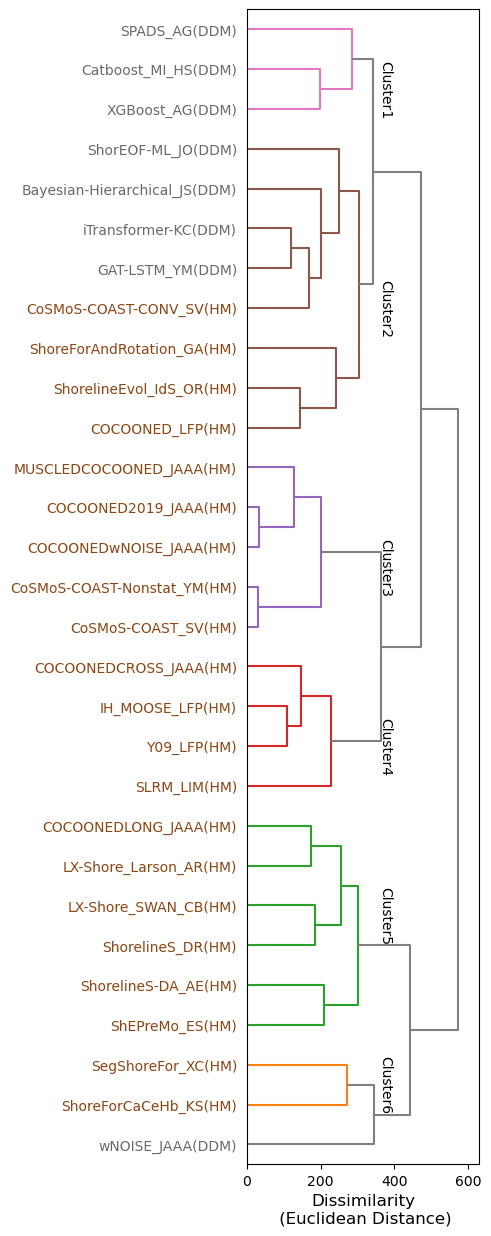

In [60]:
ensemble_norm = (ensemble_values - np.expand_dims(ensemble_values.mean(1), 1))/np.expand_dims(ensemble_values.std(1), 1)
#ensemble_norm = (ensemble_values-np.mean(ensemble_values))/np.std(ensemble_values)

time_series_data = ensemble_norm.transpose(0, 2, 1).reshape(ensemble_norm.shape[0], -1)
#time_series_data = ensemble_norm[:, :, [0,2]].transpose(0, 2, 1).reshape(ensemble_norm.shape[0], ensemble_norm.shape[1]*2)
#time_series_data = ensemble_norm[:, :, 0]


colors = {
    'DDM': 'dimgray',
    'HM': 'saddlebrown',
}

fig, ax = plt.subplots(1, 1, figsize=(3, 15))
color_threshold = 325
n_clusters = 7
model_labels = [name + '({})'.format(MODEL_TYPES[name]) for name in list(dfs_pred.keys())[:-1]]

# Step 2: Compute the Euclidean distance matrix
distance_matrix = pdist(time_series_data, metric='euclidean')

# Step 3: Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method='ward', optimal_ordering=True)
dendro = dendrogram(
    linkage_matrix,
    labels=model_labels,
    leaf_rotation=0,  # Rotate labels for better readability
    leaf_font_size=10,  # Adjust font size
    color_threshold=color_threshold,  # Threshold for coloring clusters (adjust as needed)
    above_threshold_color='gray',  # Tree branches above the threshold
    ax=ax,
    orientation='right'
)


#cluster_ids = fcluster(linkage_matrix, t=color_threshold, criterion='distance')
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids[cluster_ids==1] = 2 # merge cluster 6 and 7 which only has one element
#n_clusters = 6

# Get the unique clusters and assign cluster names
unique_clusters = np.unique(cluster_ids)
cluster_mapping = dict(zip(model_labels, cluster_ids))

# Step 8: Annotate the clusters
# Extract the x-coordinates and y-coordinates for each cluster
for cluster_id in unique_clusters:
    # Find all model names belonging to this cluster
    cluster_members = [name for name, cluster in cluster_mapping.items() if cluster == cluster_id]
    
    # Find the x-coordinates of leaves for this cluster (based on dendrogram order)
    y_positions = [
        dendro['ivl'].index(name) for name in cluster_members
    ]
    y = np.mean(y_positions)*10  # Center of cluster
    x = color_threshold + 50  # Slightly above the threshold
    
    
    if cluster_id == 2:
        y = y+10
    elif cluster_id == 3:
        y = y +7.5   
   
        
    ax.text(
    x, y, f"Cluster{n_clusters-cluster_id+1}",
    ha='center', va='center', fontsize=10, color='black', rotation=-90,
    )

# Step 5: Adjust the plot aesthetics
ax.set_xlabel("Dissimilarity\n (Euclidean Distance)", fontsize=12)

# Dynamically adjust tree height to proportionally fit the screen
ax.set_xlim(0, np.max(linkage_matrix[:, 2]) * 1.1)  # Add 10% padding to the y-axis

y_labels = ax.get_yticklabels()
for label in y_labels:
    model = label.get_text()  # Get the model name
    label.set_color(colors[MODEL_TYPES[model.split('(')[0]]])  # Set the color from the dictionary

In [53]:
n_clusters

7

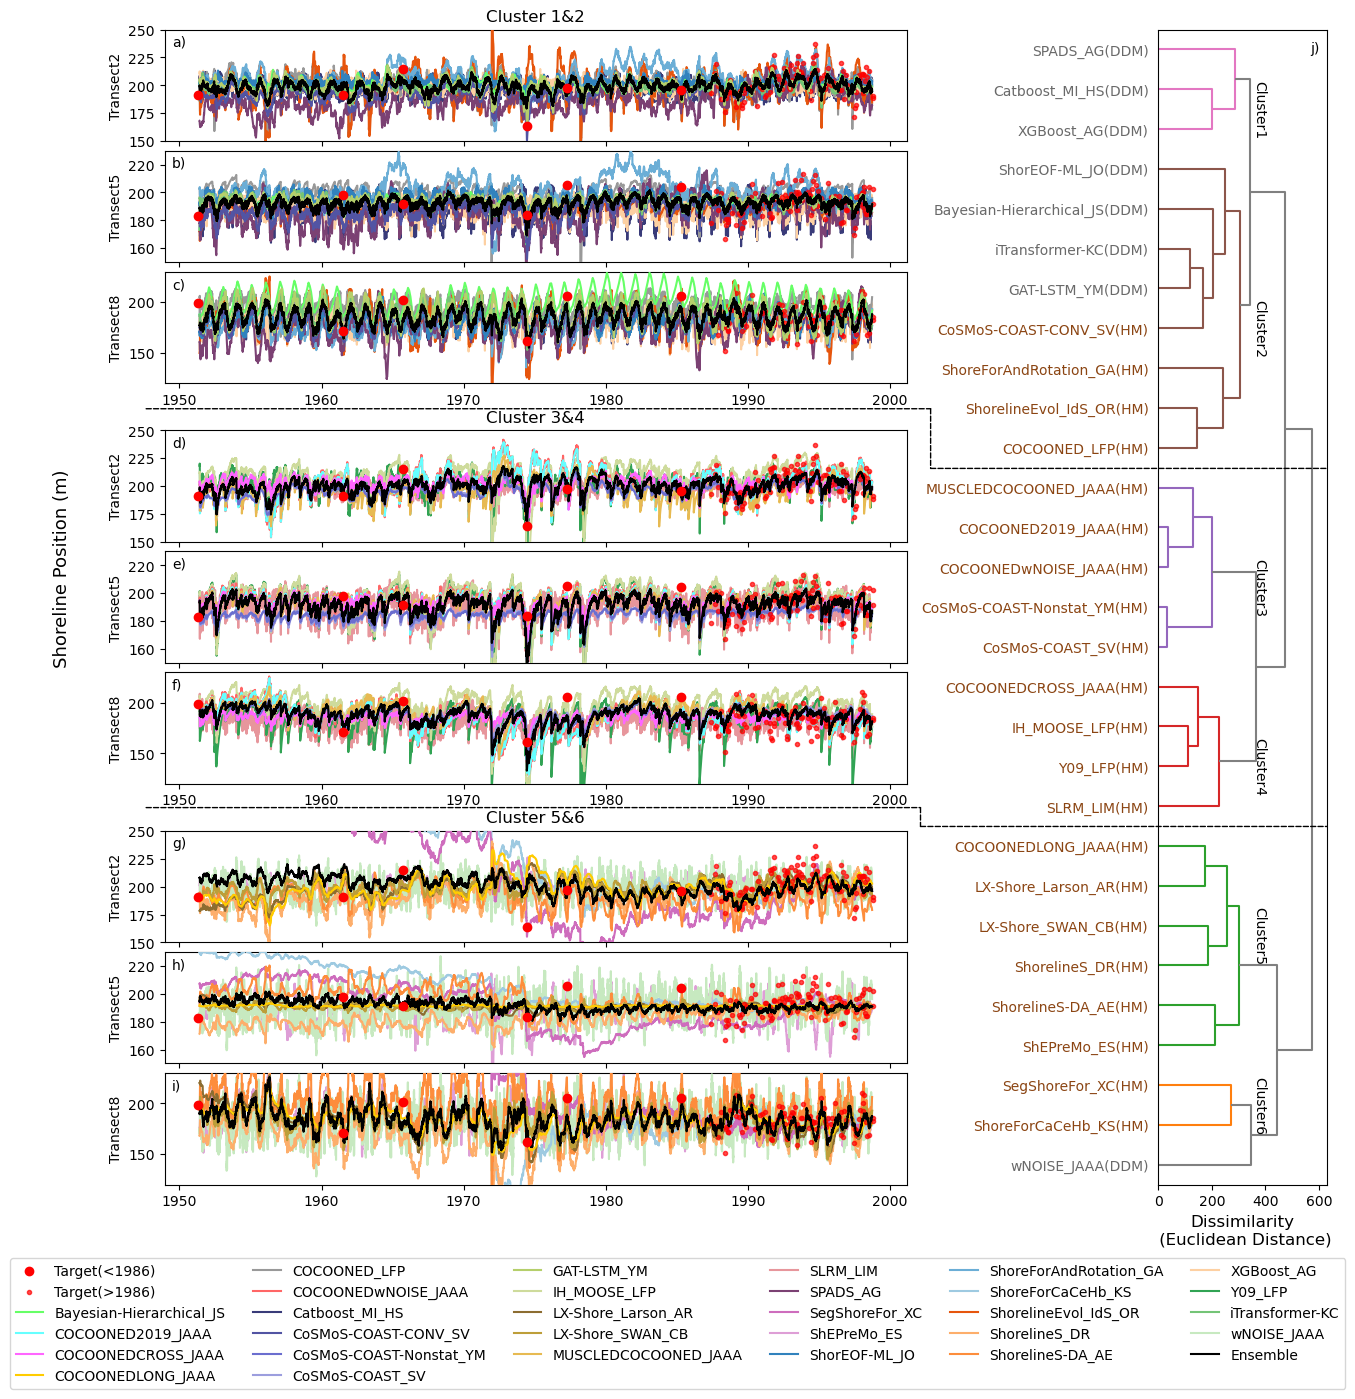

In [62]:
ensemble_norm = (ensemble_values - np.expand_dims(ensemble_values.mean(1), 1))/np.expand_dims(ensemble_values.std(1), 1)
#ensemble_norm = (ensemble_values-np.mean(ensemble_values))/np.std(ensemble_values)

time_series_data = ensemble_norm.transpose(0, 2, 1).reshape(ensemble_norm.shape[0], -1)
#time_series_data = ensemble_norm[:, :, [0,2]].transpose(0, 2, 1).reshape(ensemble_norm.shape[0], ensemble_norm.shape[1]*2)
#time_series_data = ensemble_norm[:, :, 0]


colors = {
    'DDM': 'dimgray',
    'HM': 'saddlebrown',
}

fig = plt.figure(figsize=(15, 15))
letters = string.ascii_lowercase # Letters used to label subplots
gs = GridSpec(11, 3, figure=fig, width_ratios=[11, 1.7, 2.5], height_ratios=[1, 1, 1, 0.25, 1, 1, 1, 0.25, 1, 1, 1])

#===========================================
# Create a dendrogram with Ward's linkage
#===========================================
ax = fig.add_subplot(gs[:, 2])
ax.text(0.9,0.99, letters[9] + ')', ha='left',va='top', transform=ax.transAxes, zorder=10)


color_threshold = 325
n_clusters = 7
model_labels = [name + '({})'.format(MODEL_TYPES[name]) for name in list(dfs_pred.keys())[:-1]]

# Step 2: Compute the Euclidean distance matrix
distance_matrix = pdist(time_series_data, metric='euclidean')

# Step 3: Perform hierarchical clustering using Ward's method
linkage_matrix = linkage(distance_matrix, method='ward', optimal_ordering=True)
dendro = dendrogram(
    linkage_matrix,
    labels=model_labels,
    leaf_rotation=0,  # Rotate labels for better readability
    leaf_font_size=10,  # Adjust font size
    color_threshold=color_threshold,  # Threshold for coloring clusters (adjust as needed)
    above_threshold_color='gray',  # Tree branches above the threshold
    ax=ax,
    orientation='right'
)


#cluster_ids = fcluster(linkage_matrix, t=color_threshold, criterion='distance')
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids[cluster_ids==1] = 2 # merge cluster 6 and 7 which only has one element
#n_clusters = 6

# Get the unique clusters and assign cluster names
unique_clusters = np.unique(cluster_ids)
cluster_mapping = dict(zip(model_labels, cluster_ids))

# Step 8: Annotate the clusters
# Extract the x-coordinates and y-coordinates for each cluster
for cluster_id in unique_clusters:
    # Find all model names belonging to this cluster
    cluster_members = [name for name, cluster in cluster_mapping.items() if cluster == cluster_id]
    
    # Find the x-coordinates of leaves for this cluster (based on dendrogram order)
    y_positions = [
        dendro['ivl'].index(name) for name in cluster_members
    ]
    y = np.mean(y_positions)*10  # Center of cluster
    x = color_threshold + 50  # Slightly above the threshold
    
    
    if cluster_id == 2:
        y = y+10
    elif cluster_id == 3:
        y = y +7.5   
   
        
    ax.text(
    x, y, f"Cluster{n_clusters-cluster_id+1}",
    ha='center', va='center', fontsize=10, color='black', rotation=-90,
    )

# Step 5: Adjust the plot aesthetics
ax.set_xlabel("Dissimilarity\n (Euclidean Distance)", fontsize=12)

# Dynamically adjust tree height to proportionally fit the screen
ax.set_xlim(0, np.max(linkage_matrix[:, 2]) * 1.1)  # Add 10% padding to the y-axis

y_labels = ax.get_yticklabels()
for label in y_labels:
    model = label.get_text()  # Get the model name
    label.set_color(colors[MODEL_TYPES[model.split('(')[0]]])  # Set the color from the dictionary
    

    
#================================================================
# Plot time series for each cluster
#================================================================

cluster_group = {
    0: [1, 2],
    1: [3, 4],
    2: [5, 6]
}

ylims = {
    0:[150, 250],
    1:[150, 230],
    2:[120, 230]
}

for key, group in cluster_group.items():
    count = key*3
    ax_pos = key*4
    cluster_members = []
    for cluster_id in group:
        for name, cluster in cluster_mapping.items():
            if cluster == n_clusters-cluster_id+1:
                cluster_members.append(name)
                      
        
    for tran_id in range(len(TRANSECTS)):
        ax_ts = fig.add_subplot(gs[ax_pos, 0])
        ax_ts.set_ylabel(TRANSECTS[tran_id])
        ax_ts.text(0.01,0.95, letters[count] + ')', ha='left',va='top', transform=ax_ts.transAxes, zorder=10)
        count+=1
        if ax_pos==5:
            ax.text(-0.15, 0, 'Shoreline Position (m)', rotation=90, transform=ax_ts.transAxes, fontsize=13)
        if tran_id!=2:
            ax_ts.set_xticklabels([])
        if tran_id==0:
            ax_ts.set_title( "Cluster " + "&".join(map(str, group)))

        ensemble_cluster = ensemble_values[np.isin(n_clusters-cluster_ids+1, group)]
        ensemble_mean = percentile_mean(ensemble_cluster, 5, 95, axis=0)


        for i, cluster_member in enumerate(cluster_members):
            model_name = cluster_member.split('(')[0]
            y = ensemble_values[model_labels.index(cluster_member), :, tran_id]
            x = data_ranges[task]
            ax_ts.plot(x, y, color=MODEL_COLORS[model_name], zorder=zorders[model_name])

        ax_ts.plot(data_ranges[task], ensemble_mean[:, tran_id], color='k', zorder=100)
        ax_ts.scatter(df_targ.index[df_targ.index>=sep_time], df_targ[TRANSECTS[tran_id]][df_targ.index>=sep_time], 
                       color='r', marker='.', zorder=41, alpha=0.7)

        ax_ts.scatter(df_targ.index[df_targ.index<sep_time], df_targ[TRANSECTS[tran_id]][df_targ.index<sep_time], 
               color='r', marker='o', zorder=100, alpha=1)
        ax_ts.set_ylim(ylims[tran_id])


        ax_pos+=1

# Add legend
ax_ts.scatter([], [], color='r', 
    marker='o', zorder=100, alpha=1, label='Target(<1986)')
ax_ts.scatter([], [], color='r', 
    marker='.', zorder=100, alpha=0.7, label='Target(>1986)')

for model_name in list(dfs_pred.keys()):
    ax_ts.plot([], [], color=MODEL_COLORS[model_name], zorder=zorders[model_name], label=model_name)
 
    
ax_ts.legend(ncol=6, fontsize=10, bbox_to_anchor=[1.6,-0.6], loc=1)

# Connect patches
con1_1 = ConnectionPatch((-6, 2/3+0.005), (-1.35, 2/3+0.005), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')
con1_2 = ConnectionPatch((-1.35, 2/3+0.005), (-1.35, 0.62), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')
con1_3 = ConnectionPatch((-1.35, 0.62), (1, 0.62), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')

fig.add_artist(con1_1)
fig.add_artist(con1_2)
fig.add_artist(con1_3)

con2_1 = ConnectionPatch((-6, 1/3-0.007), (-1.41, 1/3-0.007), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')
con2_2 = ConnectionPatch((-1.41, 1/3-0.007), (-1.41, 0.31), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')
con2_3 = ConnectionPatch((-1.41, 0.31), (1, 0.31), coordsA=ax.transAxes, coordsB=ax.transAxes,
                     linewidth=1, linestyle='--')

fig.add_artist(con2_1)
fig.add_artist(con2_2)
fig.add_artist(con2_3)



plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/paper/Fig3.jpg', dpi=600, bbox_inches='tight')